https://www.kaggle.com/schirmerchad/bostonhoustingmlnd/kernels

- 'RM' is the average number of rooms among homes in the neighborhood.
- 'LSTAT' is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- 'PTRATIO' is the ratio of students to teachers in primary and secondary schools in the neighborhood.
- MEDV: median value of owner-occupied homes

In [58]:
import pandas as pd
import scipy.stats as stats
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import time

from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit, train_test_split

In [59]:
df = pd.read_csv('housing.csv')

In [60]:
prices = df.MEDV

minimum_price = np.min(prices)
maximum_price = np.max(prices)
mean_price = np.mean(prices)
median_price = np.median(prices)
std_price = np.std(prices)

print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${:,.2f}".format(minimum_price))
print("Maximum price: ${:,.2f}".format(maximum_price))
print("Mean price: ${:,.2f}".format(mean_price))
print("Median price ${:,.2f}".format(median_price))
print("Standard deviation of prices: ${:,.2f}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


## Data expected behaviour

- Would you expect a home that has an 'RM' value(number of rooms) of 6 be worth more or less than a home that has an 'RM' value of 7? - As the number of rooms increases, in most of the cases, the Floor Area increases which in-turn increases the price of the house. So, a house that has an 'RM' value(number of rooms) of 6 will have a lesser worth than a home that has an 'RM' value of 7. ('RM vs 'Price' is a Positive Correlation)

- Would you expect a neighborhood that has an 'LSTAT' value(percent of lower class workers) of 15 have home prices be worth more or less than a neighborhood that has an 'LSTAT' value of 20? - Usually, high-class socities tend to have a higher home prices. So, as the percent of lower class workers decreases, the price of the house will increase. In this case, a neighborhood that has an 'LSTAT' value(percent of lower class workers) of 15 have home prices worth more than a neighborhood that has an 'LSTAT' value of 20. ('LSTAT' vs 'Price' is a Negative Correlation)

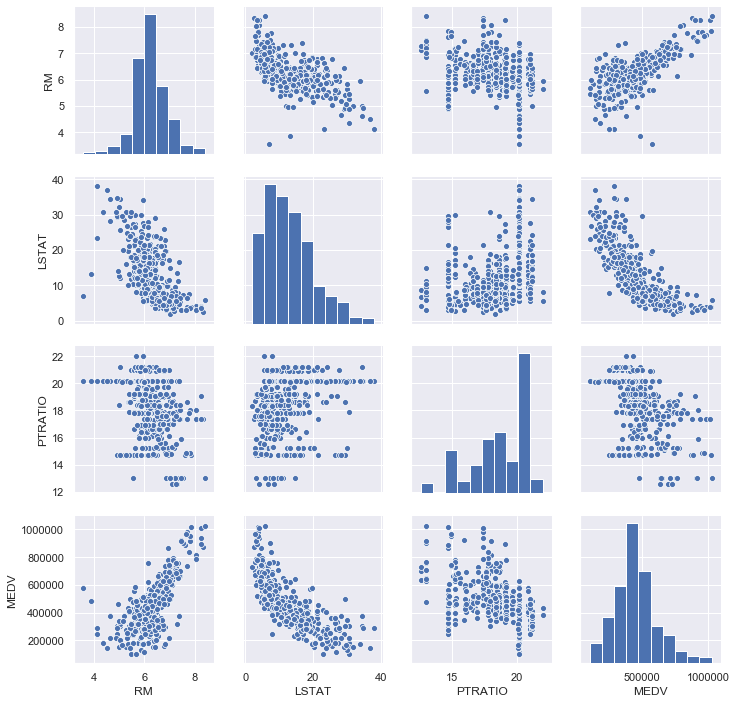

In [61]:
sns.pairplot(df)

## Removing outliers

In [62]:
df.drop([353,355], inplace=True)

## Forest Regressor 

In [63]:
X = df[['RM', 'LSTAT', 'PTRATIO']]
y = df.MEDV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, 
                               verbose=0, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

y_pred = rf_random.predict(X_test)

In [65]:
best_score = rf_random.best_score_
best_params = rf_random.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Best score: 0.8120477747652931
Best params: 
bootstrap: True
max_depth: 10
max_features: 'sqrt'
min_samples_leaf: 2
min_samples_split: 5
n_estimators: 1000


In [66]:
print("mean_squared_error", mean_squared_error(y_test, y_pred))
print("explained_variance_score", explained_variance_score(y_test, y_pred))
print("r2_score", r2_score(y_test, y_pred))

mean_squared_error 3755499550.5137005
explained_variance_score 0.8823506424728789
r2_score 0.8820237859652994


### Plotting some values  

In [67]:
model = rf_random

# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(model.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $354,982.59
Predicted selling price for Client 2's home: $262,200.12
Predicted selling price for Client 3's home: $874,650.67


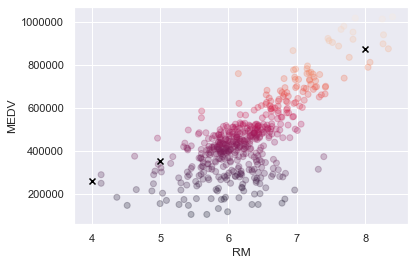

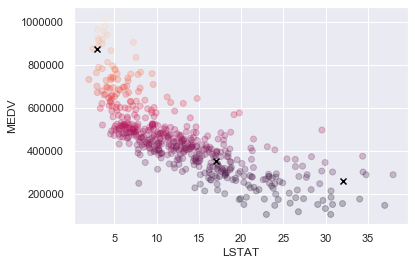

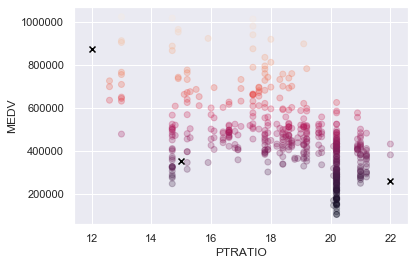

In [68]:
clients = np.transpose(client_data)
pred = model.predict(client_data)
for i, feat in enumerate(['RM', 'LSTAT', 'PTRATIO']):
    plt.scatter(df[feat], df.MEDV, alpha=0.25, c=df.MEDV)
    plt.scatter(clients[i], pred, color='black', marker='x', linewidths=2)
    plt.xlabel(feat)
    plt.ylabel('MEDV')
    plt.show()

### Residual prediction distribution frecuency (PDF)

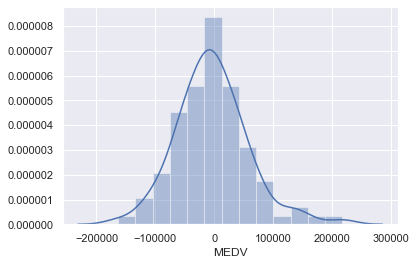

In [69]:
sns.distplot(y_test - y_pred)

- lo que es < 0 significa que la prediccion fue mayor al valor real
- lo que es > 0 significa que la prediccion fue menos al valor real

# Analyzing Model Performance
We'll investigate forest regressor algorithm on the full training set to observe how model complexity affects performance. Graphing your model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves

The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R2, the coefficient of determination.

In [70]:
###########################################
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

import matplotlib.pyplot as pl
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit, train_test_split

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

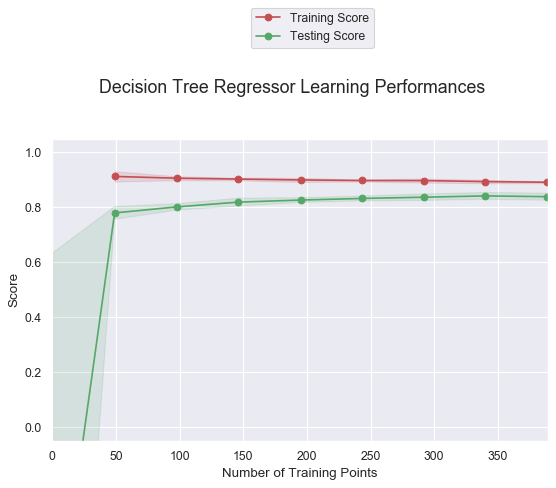

In [204]:
X = df[['RM', 'LSTAT', 'PTRATIO']]
y = df.MEDV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#DecisionTreeRegressor
regressor = RandomForestRegressor(bootstrap= True,
                                  max_depth=5,
                                  max_features='sqrt',
                                  min_samples_leaf=2,
                                  min_samples_split=2,
                                  n_estimators=500
                                 )

# Create 10 cross-validation sets for training and testing
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
cv.get_n_splits(X)

# Generate the training set sizes increasing by 50
train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

# Calculate the training and testing scores
sizes, train_scores, test_scores = learning_curve(regressor, X, y, \
    cv = cv, train_sizes = train_sizes, scoring = 'r2')

# Find the mean and standard deviation for smoothing
train_std = np.std(train_scores, axis = 1)
train_mean = np.mean(train_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')

plt.title('')
plt.xlabel('Number of Training Points')
plt.ylabel('r2 score')
plt.xlim([0, X.shape[0]*0.8])
plt.ylim([-0.05, 1.05])

plt.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
plt.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
plt.fill_between(sizes, train_mean - train_std, \
    train_mean + train_std, alpha = 0.15, color = 'r')
plt.fill_between(sizes, test_mean - test_std, \
    test_mean + test_std, alpha = 0.15, color = 'g')

# Visual aesthetics
plt.legend(bbox_to_anchor=(0.4, 1.3), loc='lower left', borderaxespad = 0.)
plt.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
plt.show()

## Sensitivity

An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted.

#### Run the code cell below to run the fit_model function ten times with different training and testing sets to see how the prediction for a specific client changes with respect to the data it's trained on.

In [72]:
def PredictTrials(X, y, model, data):
    """ Performs trials of fitting and predicting data. """

    # Store the predicted prices
    prices = []

    for k in range(10):
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, \
            test_size = 0.2, random_state = k)
        
        # Fit the data
        #reg = fitter(X_train, y_train)
        model.fit(X_train, y_train)
        reg = model
        
        # Make a prediction
        pred = reg.predict([data[0]])[0]
        prices.append(pred)
        
        # Result
        print("Trial {}: ${:,.2f}".format(k+1, pred))

    # Display price range
    print("\nRange in prices: ${:,.2f}".format(max(prices) - min(prices)))

In [73]:
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

X = df[['RM', 'LSTAT', 'PTRATIO']]
y = df.MEDV

#DecisionTreeRegressor
regressor = RandomForestRegressor(bootstrap= True,
                                  max_depth=20,
                                  max_features='sqrt',
                                  min_samples_leaf=2,
                                  min_samples_split=2,
                                  n_estimators=2000
                                 )

In [74]:
PredictTrials(X, y, regressor, client_data)

Trial 1: $351,639.54
Trial 2: $363,451.40
Trial 3: $361,580.58
Trial 4: $362,764.02
Trial 5: $362,795.42
Trial 6: $356,916.21
Trial 7: $365,715.37
Trial 8: $353,311.86
Trial 9: $363,633.35
Trial 10: $354,639.98

Range in prices: $14,075.83


### Robustness

- https://www.researchgate.net/post/What_is_the_definition_of_the_robustness_of_a_machine_learning_algorithm

The robust performance of the algorithm is the one which does not deteriorate too much when training and testing with slightly different data (either by adding noise or by taking other dataset)

- Are the features present in the data sufficient to describe a home? 

Frankly speaking we cannot exactly predict the price of a house using just 3 independent variables. There are many more factors like the 'Building Type', 'Quality of Construction', 'Year Built', 'Bathrooms', 'Kitchen Quality', 'Garages', 'Pool', 'Fence' which will give us a better estimate of any house.


- Is the model robust enough to make consistent predictions?

As the model is built on a very less number of features and some data points it will not be very robust. So, when using the predictions from this model care should be taken to consider other external factors also. (Robustness of the model was evident from the above block of code.)

# Neural Network 

In [213]:
import keras
from keras import backend
from keras.layers import Input, Dense

In [214]:
def r2_score(y_true, y_pred):
    sst = backend.square(y_true - backend.mean(y_true)) #sst = sum squared of totals
    ssr = backend.square(y_true - y_pred) #ssr = sum squared of residuals
    return 1 - (backend.sum(ssr)/backend.sum(sst))

y_true - backend.mean(y_true) -> centra los valores en 0 ( voy a tener valores + y -)
y_true - y_pred -> son los residuals, informa una medida de error de nuestro modelo con respecto a los valores reales

si r2_score == 0 -> backend.sum(ssr)/backend.sum(sst) == 1 -> sst == ssr -> mean(y_true) == y_pred
esto significa que nuestro modelo esta prediciendo el valor medio de los datos, 
no es ni bueno ni malo ( en realidad se espera algo mucho mejor )

si r2 > 0 -> backend.sum(sst) > backend.sum(ssr) -> los residuos son menores que el valor promedio de los datos 

si r2 < 0 -> backend.sum(sst) < backend.sum(ssr) -> los residuos son mayores que el valor promedio de los datos 

r2 =< 1 siempre por definicion. (backend.sum(ssr)/backend.sum(sst)) es una division de cuadrados, nunca puede dar numero negativo.

#https://en.wikipedia.org/wiki/Coefficient_of_determination
#https://stats.stackexchange.com/questions/12900/when-is-r-squared-negative#12991

In [215]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=[len(X_train.keys())]),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1)
    ])

    model.compile(optimizer='rmsprop',
                  loss='mse',   
                  metrics=['mae', r2_score])
    return model

In [216]:
X = df[['RM', 'LSTAT', 'PTRATIO']]
y = df.MEDV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = build_model()

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

EPOCHS = 400#1000

model.fit(
  X_train, y_train,
  epochs=EPOCHS, batch_size=128, validation_split = 0.2, verbose=0)

score = model.predict(X_test)

from sklearn.metrics import accuracy_score

print(explained_variance_score(y_test, score))

from sklearn.metrics import r2_score 

print(r2_score(y_test, score))

0.8784252891197994
0.8738552093563119


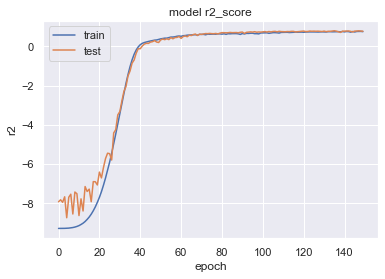

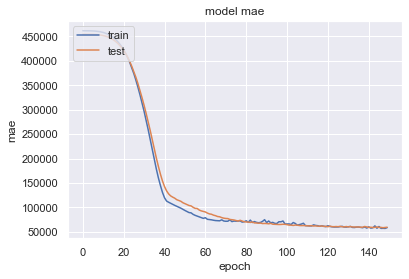

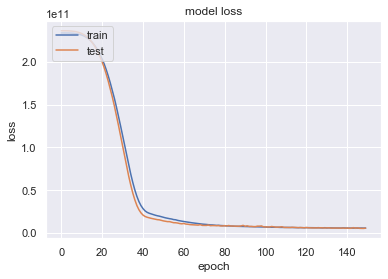

In [196]:
history = model.history

# summarize history for r2
plt.plot(history.history['val_r2_score'])
plt.plot(history.history['r2_score'])
plt.title('model r2_score')
plt.ylabel('r2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for mae
plt.plot(history.history['val_mae'])
plt.plot(history.history['mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/